<div style="text-align:center;">
    <h1><b>RAMP on predicting cyclist traffic in Paris</b></h1>
</div>

# Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
 The target is: `log bike count`
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

# Part 1: Exploratory Data Analysis (EDA)

This notebook segment is focused on exploring the bike traffic dataset provided by the Paris city council. Our objective is to understand the fundamental characteristics of the dataset, scrutinize the variables, and handle preliminary data checks. This exploration is crucial as it sets the foundation for subsequent feature engineering and modeling

Key steps undertaken in this EDA include:

- Evaluating the dataset's structure and variable types
- Preliminary assessment for missing values
- Identification of unique entries per variable
- Exploration of station frequencies to understand traffic distribution
- Descriptive statistics to summarize the data's central tendency, dispersion, and shape
- Initial visualizations to identify potential outliers and understand data distributions

In [20]:
# installs

#pip install pyarrow
#pip install fastpaquet
#pip install ydata_profiling
#pip install folium

   ---------------------------------------- 0.0/97.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/97.0 kB ? eta -:--:--
   ------------ --------------------------- 30.7/97.0 kB 660.6 kB/s eta 0:00:01
   ------------------------------------- -- 92.2/97.0 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 97.0/97.0 kB 923.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/56.3 kB ? eta -:--:--
   ---------------------------------------- 56.3/56.3 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
# imports
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
import ydata_profiling
import folium
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)
%matplotlib inline

Note that our Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas:

In [4]:
#Load the data
bike_df = pd.read_parquet(Path("data") / "train.parquet")

## Initial Data Inspection

In [5]:
#Check the first few observations
bike_df.head(5)

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [6]:
#Check the last few observations
bike_df.tail(5)

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
929175,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,445.0,2021-09-09 06:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.83977,2.30198,6.100319
929178,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,145.0,2021-09-09 10:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.83977,2.30198,4.983607
929181,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,218.0,2021-09-09 15:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.83977,2.30198,5.389072
929184,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,21.0,2021-09-09 22:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.83977,2.30198,3.091042
929187,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,15.0,2021-09-09 23:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.83977,2.30198,2.772589


In [7]:
# Check the shape of the dataset
print("Dataset Shape:", bike_df.shape)

Dataset Shape: (496827, 12)


We have 12 variables and 496,827 observations.

In [8]:
#Check general information on the variables
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

In our dataset, we have:
- numerical variables: `site_id`, `bike_count`, `latitute`, `longitude`, `log_bike_count`,
- categorical variables: `counter_id`, `counter_name`, `site_name`, `coordinates`, `counter_technical_id`
- datetime variables: `date`, `counter_installation_date`

In [9]:
# Check for duplicates
duplicate_rows = bike_df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

Number of duplicate rows: 0


In [10]:
# Check for missing values
bike_df.isna().sum()

counter_id                   0
counter_name                 0
site_id                      0
site_name                    0
bike_count                   0
date                         0
counter_installation_date    0
coordinates                  0
counter_technical_id         0
latitude                     0
longitude                    0
log_bike_count               0
dtype: int64

Our dataset looks clean for now, there is no duplicated rows and no missing values.

Note that we will need to check again in our part `02_feature_engineering` when adding external data

In [11]:
#Check the number of unique entries in each column
print("Unique values per column:")
print(bike_df.nunique())

Unique values per column:
counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64


We have a total of 30 unique sites where sometimes multiple counters are installed per location (56 distinct counters).  Let's look at the most frequented stations

In [12]:
# Most frequented stations
print("\nMost frequented stations:")
bike_df.groupby(["site_name", "counter_name"], observed=False)["bike_count"].sum().sort_values(
    ascending=False
).head(10).to_frame()


Most frequented stations:


,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1992227.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1551730.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1497912.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1130565.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1015875.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,984914.0
Quai d'Orsay,Quai d'Orsay E-O,948357.0
Totem Cours la Reine,Totem Cours la Reine O-E,894937.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,884907.0


Moreover, we can look at the timeframe (scope) of our dataset.

In [13]:
# Timestamp information
print("\nTimestamp information:")
earliest_time = bike_df['date'].min()
latest_time = bike_df['date'].max()
print(f"Earliest Time: {earliest_time}")
print(f"Latest Time: {latest_time}")


Timestamp information:
Earliest Time: 2020-09-01 01:00:00
Latest Time: 2021-09-09 23:00:00


Our dataset records bike count at several stations from September 1st 2020 (1am) to September 9th 2021 (23pm).

## Descriptive Statistics

We can also look at summary statistics for numerical features

In [15]:
# Descriptive statistics for numerical features
print("\nDescriptive Statistics:")
display(bike_df.describe())


Descriptive Statistics:


,site_id,bike_count,date,counter_installation_date,latitude,longitude,log_bike_count
count,4.968270e+05,496827.000000,496827,496827,496827.000000,496827.000000,496827.000000
mean,1.053450e+08,60.191475,2021-03-08 07:25:59.668858,2019-04-04 07:24:35.245911,48.854343,2.345479,3.079917
min,1.000070e+08,0.000000,2020-09-01 01:00:00,2013-01-18 00:00:00,48.826360,2.265420,0.000000
25%,1.000475e+08,5.000000,2020-12-05 22:00:00,2018-11-29 00:00:00,48.840801,2.314440,1.791759
50%,1.000562e+08,29.000000,2021-03-08 11:00:00,2019-11-06 00:00:00,48.852090,2.353870,3.401197
75%,1.000563e+08,79.000000,2021-06-09 14:00:00,2019-12-11 00:00:00,48.864610,2.375870,4.382027
max,3.000147e+08,1302.000000,2021-09-09 23:00:00,2020-11-29 00:00:00,48.891720,2.409690,7.172425
std,3.210346e+07,87.590566,NaN,NaN,0.018554,0.038026,1.659899


This descriptive statistics reveal notable insights into the bike traffic dataset collected across various sites in Paris from September 1st 2020 to September 9th 2021:

- Counts range from 0 to 1,302 bike traffic per hour which shows a broad spectrum of cycling activity.
- The average count is around 60 bikes per hour, indicating a moderate level of overall bike traffic.
- The significant standard deviation (~88) suggests substantial variability, likely influenced by time, weather, or location.
- The narrow latitude and longitude ranges (low standard deviations) indicate that the counters are situated within a specific area of the city.
- The log transformation of bike counts, averaging around 3.07, indicates a positive skew in the data, which is common in traffic counts and validates the use of log transformation for potential modeling efforts.

## Basic Data Visualization

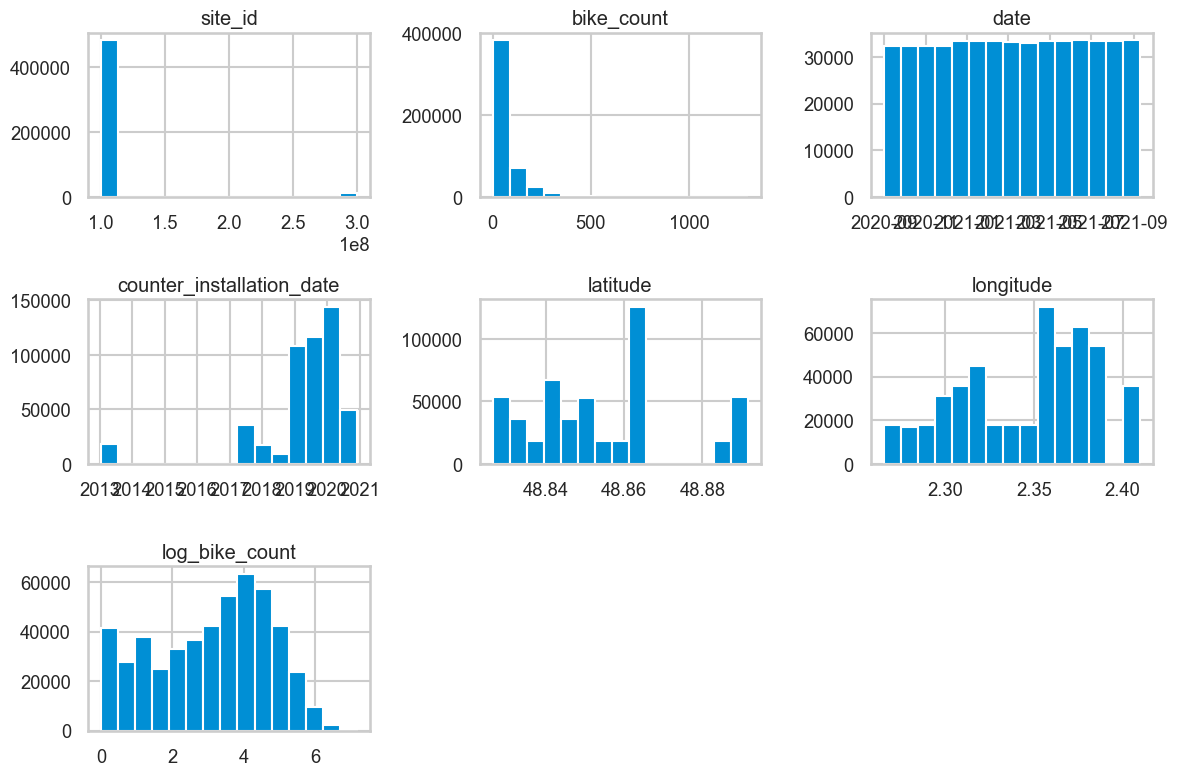

In [16]:
# Histograms for numerical data
bike_df.hist(figsize=(12, 8), bins=15)
plt.tight_layout()
plt.show()

These histograms offer a visual summary of the distribution of values across several key variables:

- `bike_count`: The distribution is heavily skewed towards lower counts, indicating that high volumes of bike traffic are less common than lower volumes.
- `date`: The relatively uniform distribution suggests that data collection was consistent over time.
- `counter_installation_date`: This histogram indicates that the installation of counters has been an ongoing process, with a notable increase in more recent years.
- `latitude` & `longitude`: The distributions of these geographical coordinates suggest that the counters are concentrated in specific areas, likely reflecting higher cyclist density zones or areas of interest for traffic monitoring.
- `log_bike_count`: The log transformation of bike counts results in a more symmetric distribution of values compared to the raw bike counts, hinting at the potential for log-normal distribution modeling or variance stabilization.

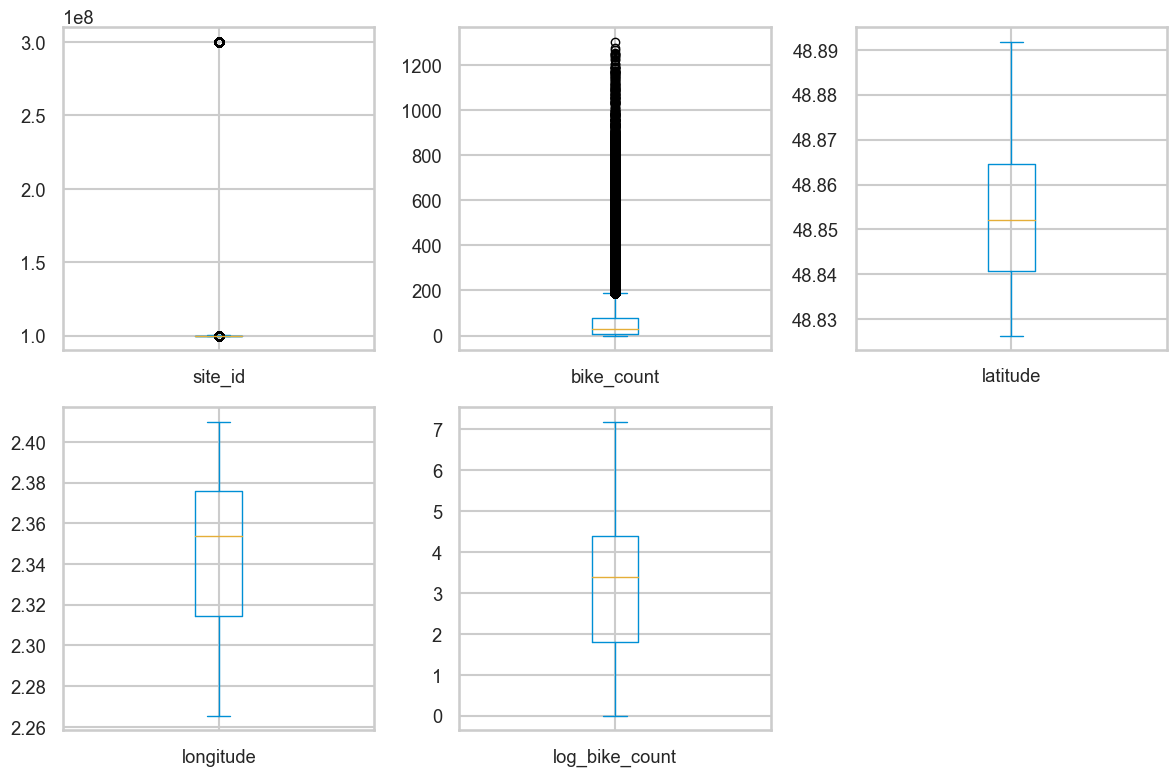

In [17]:
# Box plots for potential outliers
numerical_cols = bike_df.select_dtypes(include=['float64', 'int64']).columns
bike_df[numerical_cols].plot(kind='box', subplots=True, layout=(2,3), figsize=(12, 8))
plt.tight_layout()
plt.show()

These boxplots provide a visual representation of the data spread and potential outliers for various variables:

- `site_id`: There's little variation, with outliers due to two sites having a significantly different identifier (see below for the 2 sites).
- `bike_count`: There's a large number of outliers above the upper whisker, reflecting instances of unusually high bike traffic. The box itself is compressed at the lower end of the range, suggesting that most of the counts are low, with only a few high traffic counts.
- `log_bike_count`: The log transformation of bike counts shows a more even distribution, which suggests that extreme values in bike counts are less common.

In [15]:
# not useful I just wanted to check that I understood the boxplot correctly. Not sure why they significantly changed the site ID for these sites

# Calculate summary statistics for the site_id column
site_id_stats = bike_df['site_id'].describe()

# Check for outliers based on the IQR (Interquartile Range)
IQR = site_id_stats['75%'] - site_id_stats['25%']
lower_bound = site_id_stats['25%'] - 1.5 * IQR
upper_bound = site_id_stats['75%'] + 1.5 * IQR

# Find the potential outlier(s)
outliers = bike_df[(bike_df['site_id'] < lower_bound) | (bike_df['site_id'] > upper_bound)]

# Print the potential outlier(s)
print(outliers[['site_id', 'site_name']].drop_duplicates())

          site_id             site_name
48321   100007049  28 boulevard Diderot
912623  300014702  254 rue de Vaugirard


**Note:** The outliers identified in `bike_count` could be due to specific events or times when cycling activity is unusually high, and they will be important to consider in any further analysis, as they could influence the average values and the overall distribution. The boxplots provide a clear indication that while most cycling activity is consistent, there are periods of significant variation that need to be understood in the context of Paris's cycling infrastructure and urban dynamics.

Finally, we can use a package called `ydata_profiling` to make a nice summary report of the general analysis of our dataset.

In [18]:
bike_df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Visualization of the sites

We can also visualize the data on a map, by looking at the spatial distribution of bike counters.

In [23]:
m = folium.Map(location=bike_df[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    bike_df[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

## Conclusion

This exploratory analysis provided valuable insights into the cyclist traffic data, revealing the distribution and variability of bike counts across different sites in Paris. From identifying the most frequented stations to visualizing the spread of data points, we now have a foundational understanding of the dataset's nuances.

The next step will be to build upon this initial analysis by engaging in feature engineering. We'll aim to enrich the dataset with additional, relevant information that could include but is not limited to weather conditions, temporal features, and potential external factors that could affect bike traffic. By doing so, we anticipate uncovering deeper patterns that may not be immediately apparent from the raw data, thus enhancing the robustness and predictive power of our subsequent models.

As we transition into feature engineering, we'll carry forward the insights gained here, particularly regarding the influence of time, location, and other underlying factors that could sway cyclist activity. Our goal is to develop a model that not only predicts bike traffic with high accuracy but also provides interpretability to understand the driving forces behind cycling patterns in an urban setting like Paris.